# CNN para detección y localización de fisuras en superficies 
 <i align="center">“Hay una grieta en todo, así es como entra la luz”. - Leonard Cohen</i>

***

## Descripción

Implementación en Keras/Tensorflow de CNN para reconocer fisuras en imágenes de materiales. Se intenta reproducir el componente CNN de la cadena de procesamiento descripta en [1].  

En el paper original se utilizan placas de acero inoxidable de ~267mm. Para este ensayo se usa el dataset más parecido que se encontró [2], que contiene imágenes de fisuras en concreto con 200.000 imágenes clasificadas en "positivo" y "negativo".

> A. Inspection Videos
>To develop and evaluate the proposed framework, videos of 20 underwater specimens, that represented internal nuclearpower plant components, were collected. The specimens were made of 304 stainless steel with media blasting to limit glare from the camera lights. The widths and heights of the specimens were approximately 267 mm. Each specimen had weld crowns, different number of grinding marks, scratches, and cracks on the surface that are normally found on internal nuclear power plant components.(...)


## Referencias

1. <cite data-cite="tie-2764844-pp">NB-CNN: Deep Learning-Based Crack Detection Using Convolutional Neural Network and Naïve Bayes Data Fusion</cite>
2. <cite>Özgenel, Çağlar Fırat (2018), “Concrete Crack Images for Classification”, Mendeley Data, v1 http://dx.doi.org/10.17632/5y9wdsg2zt.1#file-c0d86f9f-852e-4d00-bf45-9a0e24e3b932</cite>


## Contenido
* [Arquitectura de la CNN](#arq)
* [Entrenamiento](#training)
* [Demostración de Uso](#demo)

In [99]:
from IPython.display import SVG
import numpy
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import image
import numpy as np

In [100]:
# Configuration
CHECKPOINT_BASE_PATH = "../../checkpoints/crack-detection-basic-cnn/"
CHECKPOINT_FILENAME = "weights.26-0.02.hdf5"
DATASET_BASE_PATH = "../../data/datasets/"
DATASET_PATH = "cracks-redux/"

plt.rcParams['figure.figsize'] = [10, 5]

## Arquitectura de la CNN<a class="anchor" id="arq"></a>

Versión simplificada con una sóla capa de convolución. El clasificador final (capa dense_2) es Sigmoid (no Softmax).

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 3,937,409
Trainable params: 3,937,409
Non-trainable params: 0
_________________________________________________________________


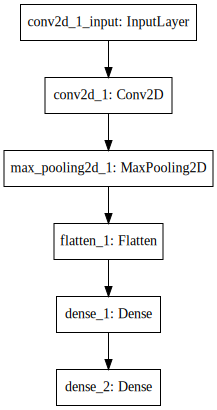

In [101]:
# load json and create model
model = load_model(CHECKPOINT_BASE_PATH+CHECKPOINT_FILENAME)
plot_model(model, show_shapes=True)
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))


## Entrenamiento <a class="anchor" id="training"></a>

#### Parámetros de Entrenamiento

Parámetro                 | Valor
--------------------------|--------------------
Algoritmo de Optimización | Adam
Función Objetivo (Loss)   | Binary Cross-Entropy
Muestras por Training Set | 400
Muestras por Test Set     | 200
Épocas                    | 30


#### Configuración del Dataset y parámetros para aumento (Keras Image Generator)

##### Tranining Set

Parámetro         | Valor
------------------|--------------------
rescale           | 1./255
shear_range       | 0.2
zoom_range        | 0.2
horizontal_flip   | True


##### Test Set

Parámetro         | Valor
------------------|--------------------
rescale           | 1./255


### Curvas de Entrenamiento: Precisión y Función Objetivo (Loss)

TODO: poner tabla con tiempo de entrenamiento, PC y accuracy y loss finales

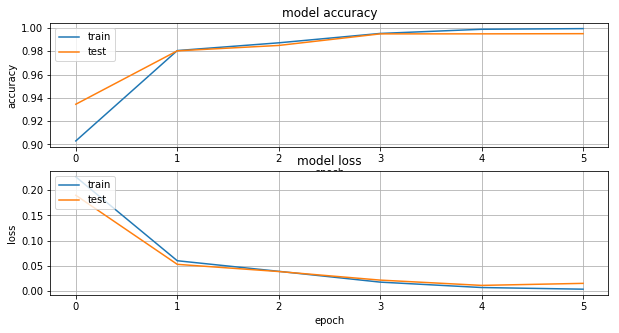

In [102]:
history_data = np.genfromtxt('history.csv', dtype=float, delimiter=',', names=True) 

# Accuracy
plt.subplot(2, 1, 1)
plt.plot(history_data['acc'])
plt.plot(history_data['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')

# Loss
plt.subplot(2, 1, 2)
plt.plot(history_data['loss'])
plt.plot(history_data['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Demostración de Uso<a class="anchor" id="demo"></a> 

### Clasificación de imágenes individuales

Ejemplo de clasificación de 16 imágenes de prueba, separadas del dataset original.

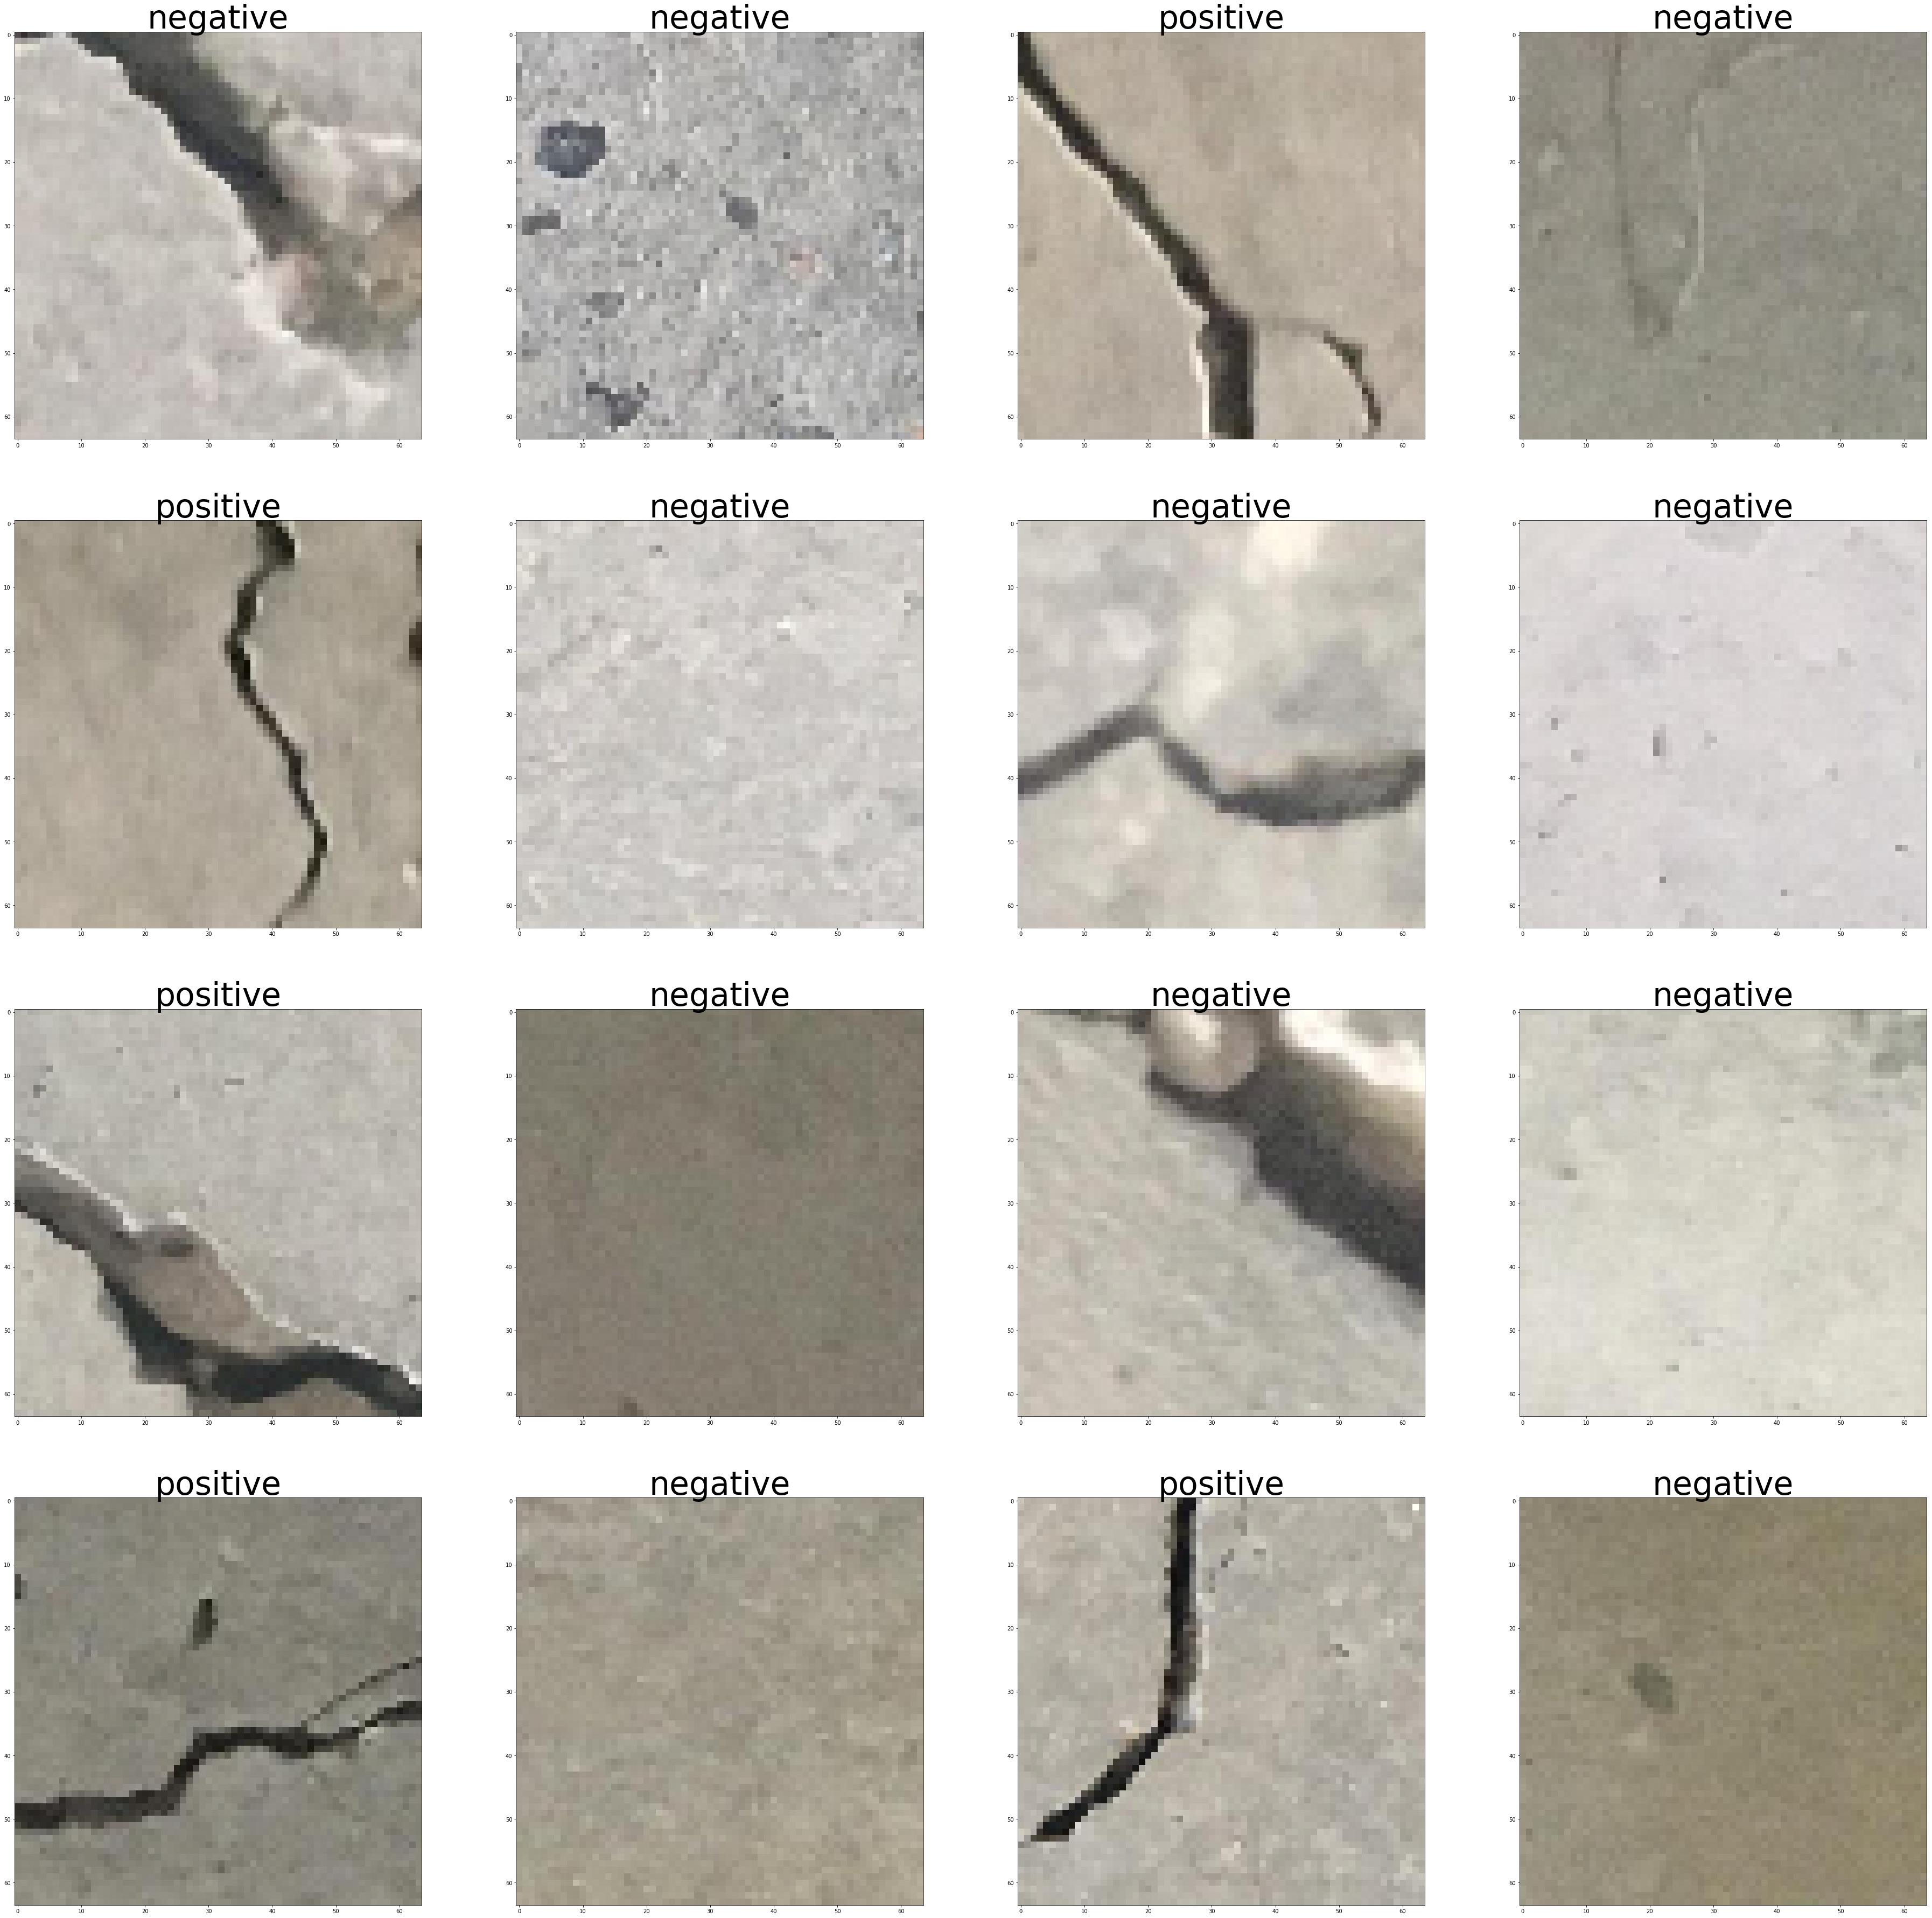

In [103]:
class_names = [ "negative", "positive" ]

fig=plt.figure(figsize=(64, 64))
n_columns = 4
n_rows = 4
for i in range(1, n_columns*n_rows +1):
    img_filename = DATASET_BASE_PATH+ DATASET_PATH + "demo/" + str(i) + '.jpg'
    img = cv2.imread(img_filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    img = cv2.resize(img, (64,64))
    fig.add_subplot(n_rows, n_columns, i)
    img_converted = img.reshape(1,64,64,3)
    predicted_class =  numpy.round(model.predict(img_converted)[0][0]).astype(int)
        
    plt.imshow(img)
    plt.title(class_names[int(predicted_class)], fontsize=60)

plt.show()

### Búsqueda de ROIs en una imagen grande

En este caso, interesa relevar de una imagen grande las regiones en las que se cree haber detectado una fisura. La imagen del ejemplo corresponde a una [Grieta en la Antártica](https://prensaantartica.com/2016/09/11/nasa-descubre-enorme-grieta-que-avanza-en-plataforma-de-hielo-en-la-antartica/)

<img src="media/grieta-3.jpg">

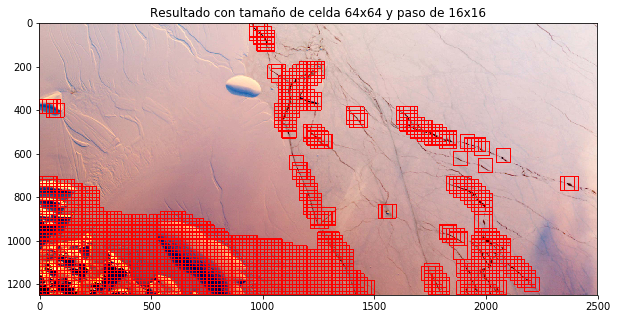

In [120]:
img = cv2.imread('media/grieta-3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
img_copy = np.copy(img)

cell_width= 64
cell_height= 64
stride_x = int(cell_width/4)
stride_y = int(cell_height/4)

for x0 in range(0,int(img.shape[1])-cell_width,stride_x):
    for y0 in range(0,int(img.shape[0])-cell_height,stride_y):            
        x1 = x0 + 64
        y1 = y0 + 64
        subimg = img[y0:y1,x0:x1]                
        subimg_converted = subimg.reshape(1,64,64,3)        
        if numpy.isclose(model.predict(subimg_converted)[0][0], 1, rtol=1e-05, atol=1e-08, equal_nan=False):
            has_crack = True
        else:
            has_crack = False
        #print(y0,x0, has_crack)
        if has_crack:
            cv2.rectangle(img_copy, (x0, y0), (x1, y1), (255,0,0), 4)

            
plt.imshow(img_copy, aspect='auto')
plt.title("Resultado con tamaño de celda 64x64 y paso de 16x16")
plt.show()